In [1]:
import numpy as np
import attocube.AMC as AMC

import time
AMC_IP = "192.168.1.78"
IP = AMC_IP

# Setup connection to AMC
amc = AMC.Device(IP)
amc.connect()

# Activate axis 1
# Internally, axes are numbered 0 to 2
axis = 1 # Axis x y z
amc.control.setControlOutput(axis, True)

## Basic settings for OL movement


In [2]:
num_steps = 100
rate_slipstick = 2000E3 # [mHz],  from 1Hz to 5kHz
out_amp = 30E3 # [mV],  from 0 to 60V
out_offset = 0.0 # [mV] from 0 to 60V

amc.control.setControlFrequency(axis, rate_slipstick)
amc.move.writeNSteps(axis, num_steps)
num_steps = amc.move.getNSteps(axis)
amc.control.setControlAmplitude(axis, out_amp)
amc.control.setControlFixOutputVoltage(axis, out_offset)

rate_slipstick = amc.control.getControlFrequency(axis) # [mHz]
out_amp = amc.control.getControlAmplitude(axis)
# out_offset = amc.control.getControlFixOutputVoltage(axis)
out_offset = amc.control.getCurrentOutputVoltage(axis)
print(f"""
Number of step per trigger: {num_steps}
Slip-stick rate: {rate_slipstick/1000.0} Hz
Slip-stick amplitdue: {out_amp/1E3} V
DC Offset: {out_offset} mV
""")


Number of step per trigger: 100
Slip-stick rate: 1999.896 Hz
Slip-stick amplitdue: 29.999 V
DC Offset: 2999 mV



## Determine the forward and backward limits

In [12]:
# amc.status.getStatusEot(axis)
fwdlimit_reached = False
bkwdlimit_reached = False

while not fwdlimit_reached:
    amc.move.setControlContinuousFwd(axis, True)
    time.sleep(0.5)
    fwdlimit_reached = amc.status.getStatusEotFwd(axis)
    print(f"Forward limit reached?: {fwdlimit_reached}") # this can't be commented out!
    amc.move.setControlContinuousFwd(axis, False)
time.sleep(0.5)
x_fwdlimit = np.floor(amc.move.getPosition(axis))

while not bkwdlimit_reached:
    amc.move.setControlContinuousBkwd(axis, True)
    time.sleep(0.5)
    bkwdlimit_reached = amc.status.getStatusEotBkwd(axis)
    print(f"Backward limit reached?: {bkwdlimit_reached}") # this can't be commented out!
    amc.move.setControlContinuousBkwd(axis, False)
time.sleep(0.5)
x_bkwdlimit = np.ceil(amc.move.getPosition(axis))

x_cen = (x_fwdlimit-x_bkwdlimit)/2.0

print(f"""
X forward limit: {x_fwdlimit} nm
X backward limit: {x_bkwdlimit} nm
X center : {x_cen} nm
""")

Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: True
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: True

X forward limit: 3281356.0 nm
X backward limit: 2042.0 nm
X center : 1639657.0 nm



## Determine movement per step

In [13]:
x_pos_listlist = []
for _ in range(10):
    backward = True
    amc.move.setControlTargetPosition(axis, x_fwdlimit) # move to the center
    amc.control.setControlMove(axis, True) 
    while not amc.status.getStatusTargetRange(axis):
        time.sleep(1.0)
    else:
        amc.control.setControlMove(axis, False)
    num_steps = 100
    amc.move.writeNSteps(axis, num_steps)
    num_steps = amc.move.getNSteps(axis)

    num_pulse = 100
    x_pos_list = np.zeros(num_pulse+1)

    while amc.status.getStatusMoving(axis):
            time.sleep(0.05)
    else:
        x_pos_list[0] = amc.move.getPosition(axis)
    sleeptime = max(2.0*num_steps/rate_slipstick*1000.0, 10E-3)
    for ii in range(num_pulse):
        amc.move.performNSteps(axis, backward)
        time.sleep(sleeptime)
        while amc.status.getStatusMoving(axis):
            time.sleep(sleeptime)
        else:
            x_pos_list[ii+1] = amc.move.getPosition(axis)

    x_pos_listlist += list(x_pos_list)
# x_moved = amc.move.getPosition(axis) - x_pos_list[0]

# dx_perstep = x_moved/(num_pulse*num_steps)
# print(f"""
# Steps per pulse: {num_steps}
# # Number of pulses: {num_pulse}
# Steps moved: {num_pulse*num_steps} 
# dx per step: {dx_perstep} nm
# """)
# # x_list = np.arange()


In [14]:
x_pos_listlist = np.array(x_pos_listlist)

In [15]:
from scipy.ndimage import shift
dx_listlist = []

xpll = np.reshape(x_pos_listlist, (int(len(x_pos_listlist)/(num_pulse+1)), num_pulse+1))
for x_pos_list in xpll:
    dx_list = x_pos_list[1:] - shift(x_pos_list, 1, cval=np.NaN)[1:]
    dx_listlist += list(dx_list)

dx_list = np.array(dx_listlist)

In [16]:
dx_sd = np.std(dx_list)
dx_mean = np.mean(dx_list)
print(f"{dx_mean}, {dx_sd}")

-32598.303818000142, 27199.76842097194


(array([  3.,   1.,   1.,   9.,  41.,  99., 194., 142.,  65.,  25.,   5.,
          4.,  16.,  20., 375.]),
 array([-99950.743 , -93192.3026, -86433.8622, -79675.4218, -72916.9814,
        -66158.541 , -59400.1006, -52641.6602, -45883.2198, -39124.7794,
        -32366.339 , -25607.8986, -18849.4582, -12091.0178,  -5332.5774,
          1425.863 ]),
 <BarContainer object of 15 artists>)

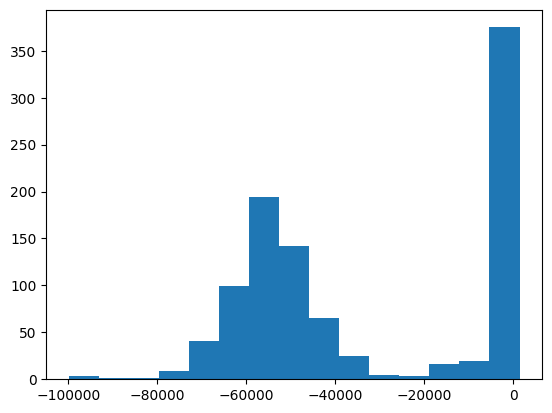

In [17]:
import matplotlib.pyplot as plt
counts, bins = np.histogram(dx_list, bins=15, range=None, density=None, weights=None)
plt.hist(bins[:-1], bins, weights=counts)

## 

In [18]:
# amc.control.getControlAmplitude(axis)
amc.control.getPositionsAndVoltages()

(3195125.619,
 -5260.968,
 6748.93,
 2999.9980273246765,
 2999.9980273246765,
 2999.9980273246765)

## Play Musics with Positioners 😝🎶


In [79]:
import pandas as pd
df = pd.read_csv('musics_notes.csv', sep=',')
dropidx = []
addrows = []
for (ii, note) in enumerate(df["Note"]):
    if "/" in note:
        note = note.replace("\xa0", "")
        sharpfat = note.split("/")
        dropidx.append(ii)
        for noteequv in sharpfat:
            addrows.append({'Note': noteequv, "Frequency (Hz)": df["Frequency (Hz)"][ii], "Wavelength (cm)": df["Wavelength (cm)"][ii]})
df = df.drop(dropidx)
df = pd.concat([df, pd.DataFrame.from_records(addrows)], ignore_index=True)
# df = df.append(addrows, ignore_index = True)
note_to_freq = dict() # note to frequency table
note_to_freq[""] = 1.0
for (ii, note) in enumerate(df["Note"]):
    note_to_freq[note] = df["Frequency (Hz)"][ii]


### Sheet Musics
Never gonna give you up

In [112]:
# beatrate = 114/4.0
beatrate = 52
# beatrate = 114/2.0
sheet = [
    'E4', 'F#4', 'G4', 'G4', 'A4', 'F#4', 'E4', 'D4', "", 
    "", 'E4', 'E4', 'F#4', 'G4', 'E4', 'D4', 'D5', "", 'D5', 'A4', "", 
    'E4', 'E4', 'F#4', 'G4', 'E4', 'G4', 'A4', "", "", 'F#4', 'E4', 'D4', "", 
    "",'E4', 'E4', 'F#4', 'G4', 'E4', 'D4', 'A4', 'A4', 'A4', 'B4', 'A4', "",
    'G4', 'A4', 'B4', 'G4', 'A4', 'A4', 'A4', 'B4', 'A4', 'D4', 
    #######
    "", 'E4', 'F#4', 'G4', 'E4', 
    "", 'A4', 'B4', 'A4', 'D4', 'E4', 'G4', 'E4', 'B4', 'B4', 'A4', 
    'D4', 'E4', 'G4', 'E4', 'A4', 'A4', 'G4', 'F#4', 'E4', 
    'D4', 'E4', 'G4', 'E4', 'G4', 'A4', 'F#4', 'E4', 'D4', 'D4', 'D4', 'A4', 'G4', 
    # never gonna make you cry
    'D4', 'E4', 'G4', 'E4', 'B4', 'B4', 'A4', 
    'D4', 'E4', 'G4', 'E4', 'D5', 'F#4', 'G4', 'F#4', 'E4', 
    'D4', 'E4', 'G4', 'E4', 'G4', 'A4', 'F#4', 'E4', 'D4',
    'D4', 'A4', 'G4', ""
]

durlist = [
    1/8, 1/8, 1/8, 1/8, 1/8, 1/8+1/16, 1/16, 1/8+1/2, 1/4, 
    1/8, 1/8, 1/8, 1/8, 1/8, 1/4, 1/8, 1/8, 1/8, 1/8, 1/8+1/16, 1/4, 
    1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8+1/16, 1/4,
    1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/4, 1/4,
    1/2+1/4, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/4, 1/4, 
    #######
    # gotta make you
    1, 1/8, 1/8, 1/8, 1/8, 
    # understand never gonna give you up
    1/8, 1/8, 1/8, 1/8+1/16, 1/16, 1/16, 1/16, 1/16, 1/8+1/16, 1/8+1/16, 1/4+1/8, 
    # never gonna let you down ----
    1/16, 1/16, 1/16, 1/16, 1/4+1/8, 1/4+1/8, 1/4+1/8, 1/16, 1/8, 
    # never gonna run around and desert you
    1/16, 1/16, 1/16, 1/16, 1/4, 1/8, 1/8+1/16, 1/16, 1/8, 1/8, 1/8, 1/4, 1/2, 
    # never gonna make you cry
    1/16, 1/16, 1/16, 1/16, 1/8+1/16, 1/8+1/16, 1/4+1/8, 
    # never gonna say goodbye
    1/16, 1/16, 1/16, 1/16, 1/4, 1/8, 1/8+1/16, 1/16, 1/8, 
    # never gonna tell a lie
    1/16, 1/16, 1/16, 1/16, 1/4, 1/8, 1/8+1/16, 1/16, 1/8,
    # and hurt you
    1/8, 1/4, 1/2, 1/4
           ]
durlist = np.array(durlist)*60.0/beatrate

In [119]:
amc.control.setControlFrequency(axis, 2000*1000)
amc.move.setControlTargetPosition(axis, x_cen)
amc.control.setControlMove(axis, True) 
while not amc.status.getStatusTargetRange(axis):
    time.sleep(1.0)
else:
    amc.control.setControlMove(axis, False)
time.sleep(0.5)
backward = False
for (note, dur) in zip(sheet, durlist): 
    backward = not (backward)
    rate_slipstick = note_to_freq[note]*1000.0 # [mHz],  from 1Hz to 5kHz
    amc.control.setControlFrequency(axis, rate_slipstick)
    rate_ss = amc.control.getControlFrequency(axis) # [mHz]
    # print(f"""
    # Slip-stick rate: {rate_ss/1000.0} Hz
    # """)
    if backward:
        amc.move.setControlContinuousBkwd(axis, True)
        time.sleep(dur)
        amc.move.setControlContinuousBkwd(axis, False)
    else:
        amc.move.setControlContinuousFwd(axis, True)
        time.sleep(dur)
        amc.move.setControlContinuousFwd(axis, False)
        
    # amc.move.performNSteps(axis, backward)


## Turn off control output and close connection

In [6]:
# Deativate axis
amc.control.setControlOutput(axis, False)

# Close connection
amc.close()